In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
pd.options.mode.chained_assignment = None

In [13]:
# this part is MACD with EMA 
def ewmacd(signals,ma1,ma2):

# the span parameter defines time window over which EMA is calculated
    signals['macd ma1']=signals['Close'].ewm(span=ma1).mean()
    signals['macd ma2']=signals['Close'].ewm(span=ma2).mean()

    return signals

def signal_generation(df,method,ma1,ma2):

    signals=method(df,ma1,ma2)
    signals['macd positions']=0
    signals['macd positions'][ma1:]=np.where(signals['macd ma1'][ma1:]>=signals['macd ma2'][ma1:],1,0)
    signals['macd signals']=signals['macd positions'].diff().fillna(0)
    signals['macd oscillator']=signals['macd ma1']-signals['macd ma2']

    return signals

In [14]:
# for awesome oscillator
# moving avg is based on the mean of high and low instead of closing price
def awesome_ma(signals):
    signals['awesome ma1'],signals['awesome ma2']=0,0
    signals['awesome ma1']=((signals['High']+signals['Low'])/2).rolling(window=5).mean()
    signals['awesome ma2']=((signals['High']+signals['Low'])/2).rolling(window=34).mean()

    return signals

In [26]:
def awesome_signal_generation(df,method):

    signals=method(df)
    signals.reset_index(inplace=True)
    signals['awesome signals']=0
    signals['awesome oscillator']=signals['awesome ma1']-signals['awesome ma2']
    signals['cumsum']=0

    for i in range(2,len(signals)):
        if signals['awesome ma1'][i]>signals['awesome ma2'][i]:
            signals.at[i,'awesome signals']=1
            signals['cumsum']=signals['awesome signals'].cumsum()
            if signals['cumsum'][i]>1:
                signals.at[i,'awesome signals']=0

        if signals['awesome ma1'][i]<signals['awesome ma2'][i]:
            signals.at[i,'awesome signals']=-1
            signals['cumsum']=signals['awesome signals'].cumsum()
            if signals['cumsum'][i]<0:
                signals.at[i,'awesome signals']=0

    signals['cumsum']=signals['awesome signals'].cumsum()

    return signals

In [27]:
# plot
def plot(new,ticker):

    fig=plt.figure()
    # positions
    ax=fig.add_subplot(211)
    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['awesome signals']==1].index,new['Close'][new['awesome signals']==1],label='AWESOME LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['awesome signals']==-1].index,new['Close'][new['awesome signals']==-1],label='AWESOME SHORT',lw=0,marker='v',c='r')
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')

    bx=fig.add_subplot(212,sharex=ax)
    new['Close'].plot(label=ticker)
    bx.plot(new.loc[new['macd signals']==1].index,new['Close'][new['macd signals']==1],label='MACD LONG',lw=0,marker='^',c='g')
    bx.plot(new.loc[new['macd signals']==-1].index,new['Close'][new['macd signals']==-1],label='MACD SHORT',lw=0,marker='v',c='r')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # oscillator
    fig=plt.figure()
    cx=fig.add_subplot(211)
    c=np.where(new['Open']>new['Close'],'r','g')
    cx.bar(range(len(new)),new['awesome oscillator'],color=c,label='awesome oscillator')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Oscillator')

    dx=fig.add_subplot(212,sharex=cx)
    new['macd oscillator'].plot(kind='bar',label='macd oscillator')
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('')
    plt.xticks([])
    plt.show()


    # moving average
    fig=plt.figure()
    ex=fig.add_subplot(211)
    new['awesome ma1'].plot(label='awesome ma1')
    new['awesome ma2'].plot(label='awesome ma2',linestyle=':')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('Moving Average')

    fig=plt.figure()
    fx=fig.add_subplot(212,sharex=bx)
    new['macd ma1'].plot(label='macd ma1')
    new['macd ma2'].plot(label='macd ma2',linestyle=':')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [28]:
# portfolio
def portfolio(signals):

    capital0=5000
    positions=100
    
    portfolio=pd.DataFrame()
    portfolio['Close']=signals['Close']

    # cumsum is used to calculate the change of value while holding shares
    portfolio['awesome holding']=signals['cumsum']*portfolio['Close']*positions
    portfolio['macd holding']=signals['macd positions']*portfolio['Close']*positions

    # basically cash is initial capital minus the profit we make from every trade
    portfolio['awesome cash']=capital0-(signals['awesome signals']*portfolio['Close']*positions).cumsum()
    portfolio['macd cash']=capital0-(signals['macd signals']*portfolio['Close']*positions).cumsum()

    portfolio['awesome asset']=portfolio['awesome holding']+portfolio['awesome cash']
    portfolio['macd asset']=portfolio['macd holding']+portfolio['macd cash']

    portfolio['awesome return']=portfolio['awesome asset'].pct_change()
    portfolio['macd return']=portfolio['macd asset'].pct_change()

    return portfolio

In [32]:
# plot how two strategies increase our asset value
def profit(portfolio):

    gx=plt.figure()
    gx.add_subplot(111)

    portfolio['awesome asset'].plot()
    portfolio['macd asset'].plot()

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Awesome VS MACD')
    plt.show()

In [33]:
def mdd(df,column):
    equity_values=df[column].values
    peaks=np.maximum.accumulate(equity_values)
    drawdowns=(equity_values - peaks) / peaks
    max_drawdown=np.nanmin(drawdowns)
    return max_drawdown

def stats(portfolio):
    stats=pd.DataFrame([0])

    # calculate some Sharpe ratios with risk free return set to 0 for simplicity, or could use SnP500 as benchmark
    stats['awesome sharpe']=(portfolio['awesome asset'].iloc[-1]/5000-1)/np.std(portfolio['awesome return'])
    stats['macd sharpe']=(portfolio['macd asset'].iloc[-1]/5000-1)/np.std(portfolio['macd return'])

    stats['awesome mdd']=mdd(portfolio,'awesome asset')
    stats['macd mdd']=mdd(portfolio,'macd asset')
    print(stats)

start date in format yyyy-mm-dd: 2022-01-01
end date in format yyyy-mm-dd: 2023-06-30
ticker: AAPL


[*********************100%%**********************]  1 of 1 completed


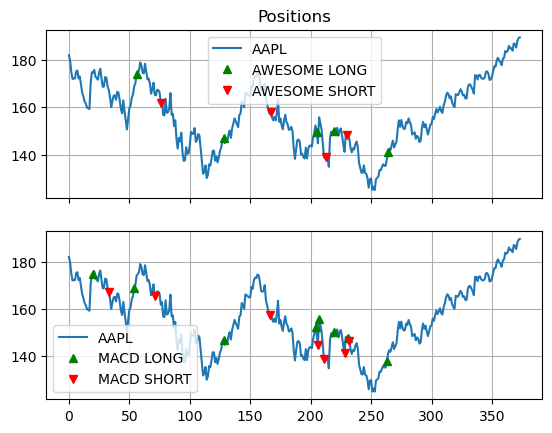

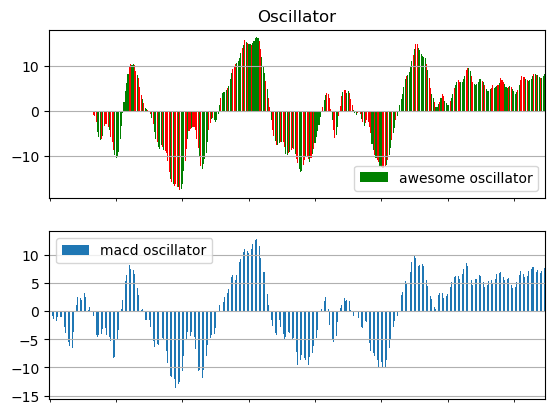

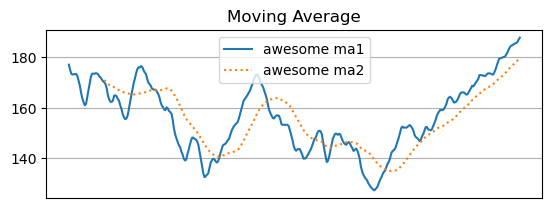

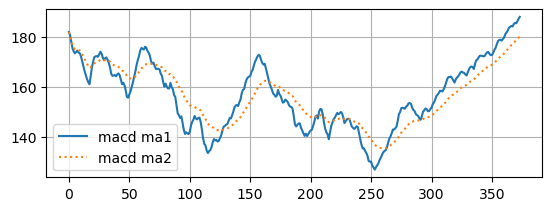

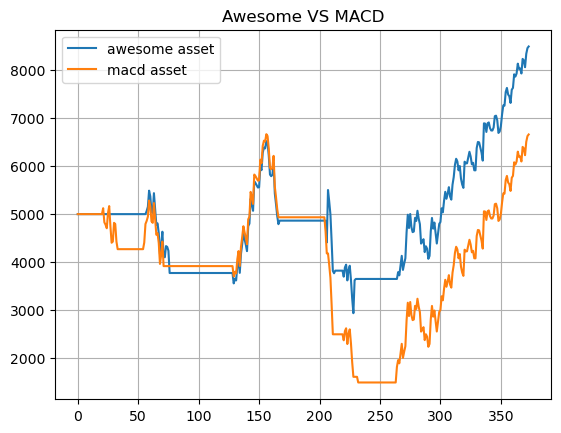

   0  awesome sharpe  macd sharpe  awesome mdd  macd mdd
0  0       18.074406     6.740667    -0.550207 -0.776661


In [34]:
def main():
    
    ma1=5
    ma2=34

    stdate=input('start date in format yyyy-mm-dd:')
    eddate=input('end date in format yyyy-mm-dd:')
    ticker=input('ticker:')
    df=yf.download(ticker,start=stdate,end=eddate)

    signals=signal_generation(df,ewmacd,ma1,ma2)
    sig=awesome_signal_generation(signals,awesome_ma)
    plot(sig,ticker)

    portfo=portfolio(sig)
    profit(portfo)
    stats(portfo)

if __name__ == '__main__':
    main()
    #2022-01-01
    #2023-06-30
    #AAPL